### Objective: 
Anthony, Tong and I have decided to do the ['Melbourne University AES/MathWorks/NIH Seizure Prediction'](https://www.kaggle.com/c/melbourne-university-seizure-prediction) competition. 

The goal of this competition is to develop a classifier that distinguishes betewen a non seizure (pre-ictal) and (interictal) seziure activity in humans. 

Here I am doing some initial exploratory analysis. 

In this notebook, I will first look at the data numerically, and then look at several of the training examples. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bokeh.plotting import figure, output_file, output_notebook, show
import scipy
import seaborn as sns
from os.path import join,dirname
from os import listdir
from scipy.io import loadmat
%matplotlib inline

sns.set_style('white')
sns.set_context('talk')

/Users/crivera5/.virtual_envs/Kaggle/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
def convert_index_to_timedelta(index, sampling_rate=400):
    """converts the index to time delta"""
    index = [i*1.0/sampling_rate for i in index]
    return pd.to_timedelta(index,'s')
    

def load_data(path,convert_index=True):
    """converts the data to a pandas object
    Parameters: 
        path(str): absolute path to the m file 
        convert_index(bool): if True, convert the index to a time delta
    Returns: 
        (data,sampling_rate,sequence):(pd.DataFrame, int, int) 
    """
    # load the matlab file and extract the data
    data = loadmat(path)['dataStruct']
    
    # get the sampling rate and cast to int
    sampling_rate = int(data['iEEGsamplingRate'][0][0])
    
    #extract the iEEG traces and electrode channel data and place into a data frame
    traces = data['data'][0][0]
    channels = data['channelIndices'][0][0][0]
    df = pd.DataFrame(traces, columns = channels)
    
    if convert_index: 
        df.index = convert_index_to_timedelta(df.index, sampling_rate)
    
    #get the sequence collection number if present (not present in test)
    sequence = -1
    if 'sequence' in data.dtype.names:
        sequence =int(data['sequence'])

    return df, sampling_rate, sequence

### Get some data
Below, I load some of the data for one of the patients. 
As I understand the data 

In [5]:
base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
train1_path = join(base, 'train_1')
train2_path = join(base, 'train_2')
train3_path = join(base, 'train_3')

In [6]:
data = load_data(join(train1_path,'1_1_0.mat'))

In [7]:
traces1 =  data[0].resample('1s').mean()
    

In [12]:
def scale(x):
    '''scales a series by subtracting the mean and dividing by std'''
    return (x-np.mean(x))/np.std(x)

def plot_ts(tsdata,columns = -1): 
    """plots the timeseries
    Parameters: 
        tsdata(pd.DataFrame): the data 
        column: the columns to use
    """
    
    if columns>0: 
        tsdata = tsdata.iloc[:,columns]
    
    # scale the data 
    scaled = tsdata.apply(scale)
    
    
    # unstack the data, reset the columns and change the names
    ts = pd.DataFrame(scaled.unstack())
    ts.reset_index(inplace = True)
    ts.columns = ['Position', 'Time','Signal']
    
    # plot the data
    
    ax = sns.tsplot(time="Time", value="Signal",data = ts ,condition = 'Position', unit = 'Position')
    
    sns.despine()
    return ax


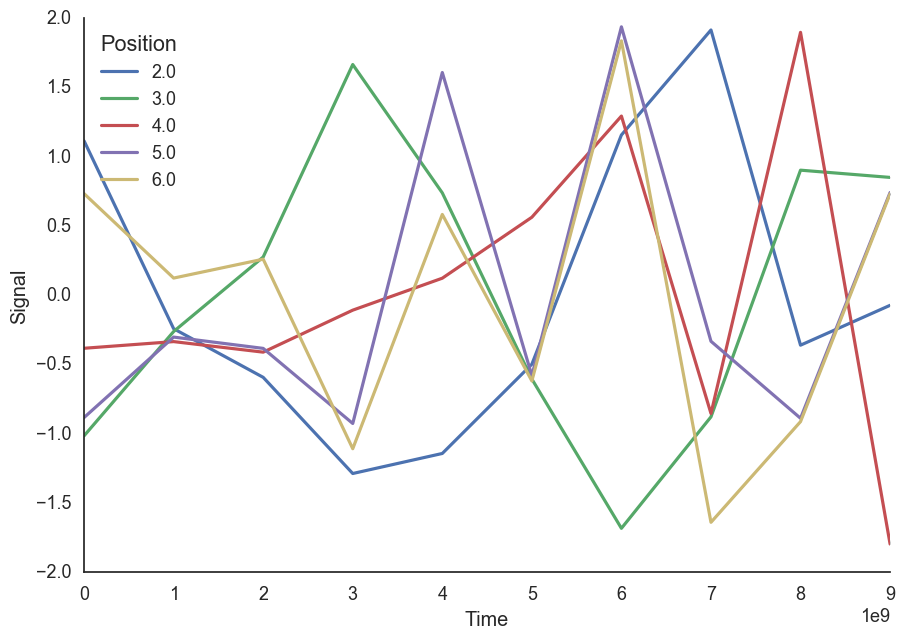

In [18]:
plot_ts(traces1.iloc[:10,:],[1,2,3,4,5])

In [ ]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")




# Compute the correlation matrix
corr = scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# data[0].index = convert_index_to_timedelta(data[0].index)

In [ ]:
data[0].plot()

In [ ]:
pd.to_timedelta(data[0].index)

In [ ]:
gammas = sns.load_dataset("gammas")


In [ ]:
nonseizure[0].head()

In [ ]:
nonseizure[1]

In [ ]:
seizure = mat_to_pandas(join(train1_path, '1_1_1.mat'))

In [ ]:
seizure[0].head()

### Investigating how to look at the data. 
I 

In [ ]:
output_notebook()
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
p.circle(nonseizure[0].index, nonseizure[0].iloc[:,4], color = 'red')
p.circle(seizure[0].index, seizure[0].iloc[:,4], color = 'green')
show(p)